[Reference](https://levelup.gitconnected.com/anomaly-detection-in-time-series-data-with-python-5a15089636db)

# Algorithm: Isolation Forest

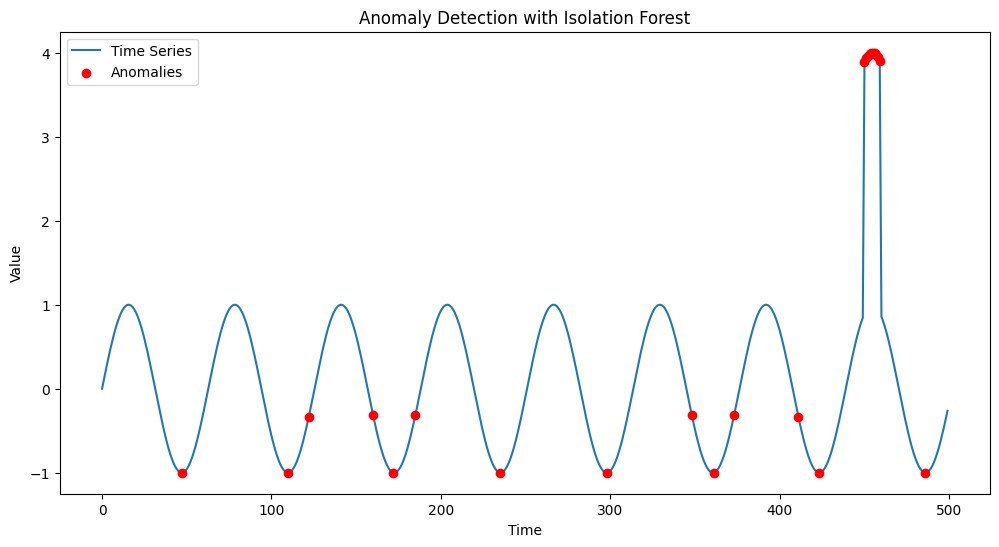

Number of anomalies detected: 24
Anomaly indices: [ 47 110 122 160 172 185 235 298 348 361 373 411 423 450 451 452 453 454
 455 456 457 458 459 486]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Simulated Time Series with Anomalies
np.random.seed(42)
normal_data = np.sin(np.linspace(0, 50, 500))  # Sine wave as normal data
anomaly_data = normal_data.copy()
anomaly_data[450:460] += 3  # Inject anomalies

# Reshape and Scale Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(anomaly_data.reshape(-1, 1))

# Train Isolation Forest Model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(scaled_data)

# Compute Anomaly Scores
scores = iso_forest.decision_function(scaled_data)
scores = -scores  # Invert scores so that higher values indicate more anomalous points

# Identify Anomalies: Points with Low Decision Function Values
threshold = np.percentile(scores, 95)  # Top 5% as anomalies
anomalies = np.where(scores > threshold)[0]

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(anomaly_data, label="Time Series")
plt.scatter(anomalies, anomaly_data[anomalies], color='red', label="Anomalies", zorder=5)
plt.title("Anomaly Detection with Isolation Forest")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig('anomaly_detection_isolation_forest.png')
plt.show()

print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Anomaly indices: {anomalies}")

# Autoencoders for Anomaly Detection

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0740 - val_loss: 0.0125
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0242 - val_loss: 0.0122
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0182 - val_loss: 0.0057
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0134 - val_loss: 0.0035
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0086 - val_loss: 0.0017
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0044 - val_loss: 9.5126e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0046 - val_loss: 9.6737e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0038 - val_loss: 8.7841e-04
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0

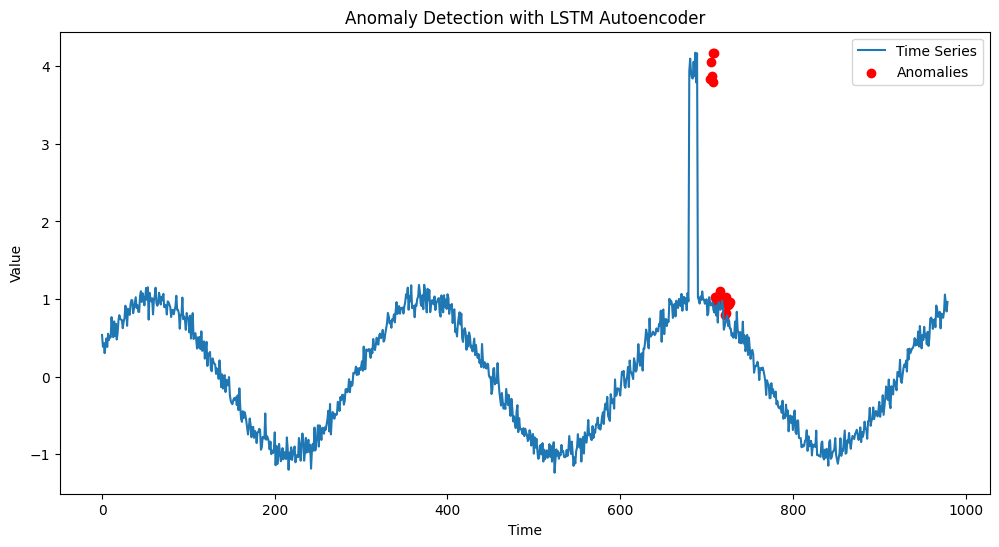

Number of anomalies detected: 24


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping

def generate_data(n_points=1000, anomaly_start=700, anomaly_end=710):
    time = np.arange(n_points)
    data = np.sin(0.02 * time) + np.random.normal(0, 0.1, n_points)
    data[anomaly_start:anomaly_end] += 3  # Inject anomalies
    return data

def prepare_data(data, window_size=20):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    X = np.array([data_scaled[i:i+window_size] for i in range(len(data_scaled) - window_size)])
    return X, scaler

def create_model(window_size):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(window_size, 1), return_sequences=True),
        LSTM(16, activation='relu', return_sequences=False),
        RepeatVector(window_size),
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(32, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies(reconstruction_error, threshold=3):
    mean = np.mean(reconstruction_error)
    std = np.std(reconstruction_error)
    return reconstruction_error > mean + threshold * std

def plot_results(data, reconstruction_error, threshold=3, window_size=20):
    plt.figure(figsize=(12, 6))

    # Plot the original data
    plt.plot(data[window_size:], label="Time Series")

    # Detect anomalies
    mean = np.mean(reconstruction_error)
    std = np.std(reconstruction_error)
    anomalies = reconstruction_error > mean + threshold * std

    # Plot anomalies
    anomaly_indices = np.where(anomalies)[0] + window_size
    plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label="Anomalies")

    plt.title("Anomaly Detection with LSTM Autoencoder")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig('lstm_anomaly_detection.jpg')
    plt.show()

    return anomalies



# Main execution
if __name__ == "__main__":
    # Generate data
    data = generate_data()

    # Prepare data
    X, scaler = prepare_data(data)

    # Create and train model
    model = create_model(window_size=20)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X, X, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    # Predict and calculate reconstruction error
    X_pred = model.predict(X)
    reconstruction_error = np.mean(np.abs(X - X_pred), axis=(1, 2))

    # Detect anomalies
    anomalies = detect_anomalies(reconstruction_error)

    # Plot results
    plot_results(data, anomalies, window_size=20)

    print(f"Number of anomalies detected: {np.sum(anomalies)}")